I want to recreate the plot given me by Vanessa on the introduction page for my master thesis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the GOFC data more efficiently
GFOC_dir = "/home/dschwarz/Documents/MT/Dataset/Dataset_MSc/GFOC_RDCDFI.csv"
GFOC_data = pd.read_csv(GFOC_dir, low_memory=True)

# Load the SWMA data more efficiently
SWMA_dir = "/home/dschwarz/Documents/MT/Dataset/Dataset_MSc/SWMA_RDAWFI.csv"
SWMA_data = pd.read_csv(SWMA_dir, low_memory=True)

Download flags

In [2]:
# Load the GOFC flags
GFOC_flag_dir = "/home/dschwarz/Documents/MT/Dataset/GFOC_flags.csv"
GFOC_flags = pd.read_csv(GFOC_flag_dir, low_memory=True)
GFOC_flags['GFOC_time'] = pd.to_datetime(GFOC_flags['GFOC_time'])

# Load the SWMA flags
SWMA_flag_dir = "/home/dschwarz/Documents/MT/Dataset/SWMA_flags.csv"
SWMA_flags = pd.read_csv(SWMA_flag_dir, low_memory=True)
SWMA_flags['SWMA_time'] = pd.to_datetime(SWMA_flags['SWMA_time'])

Select relevant features

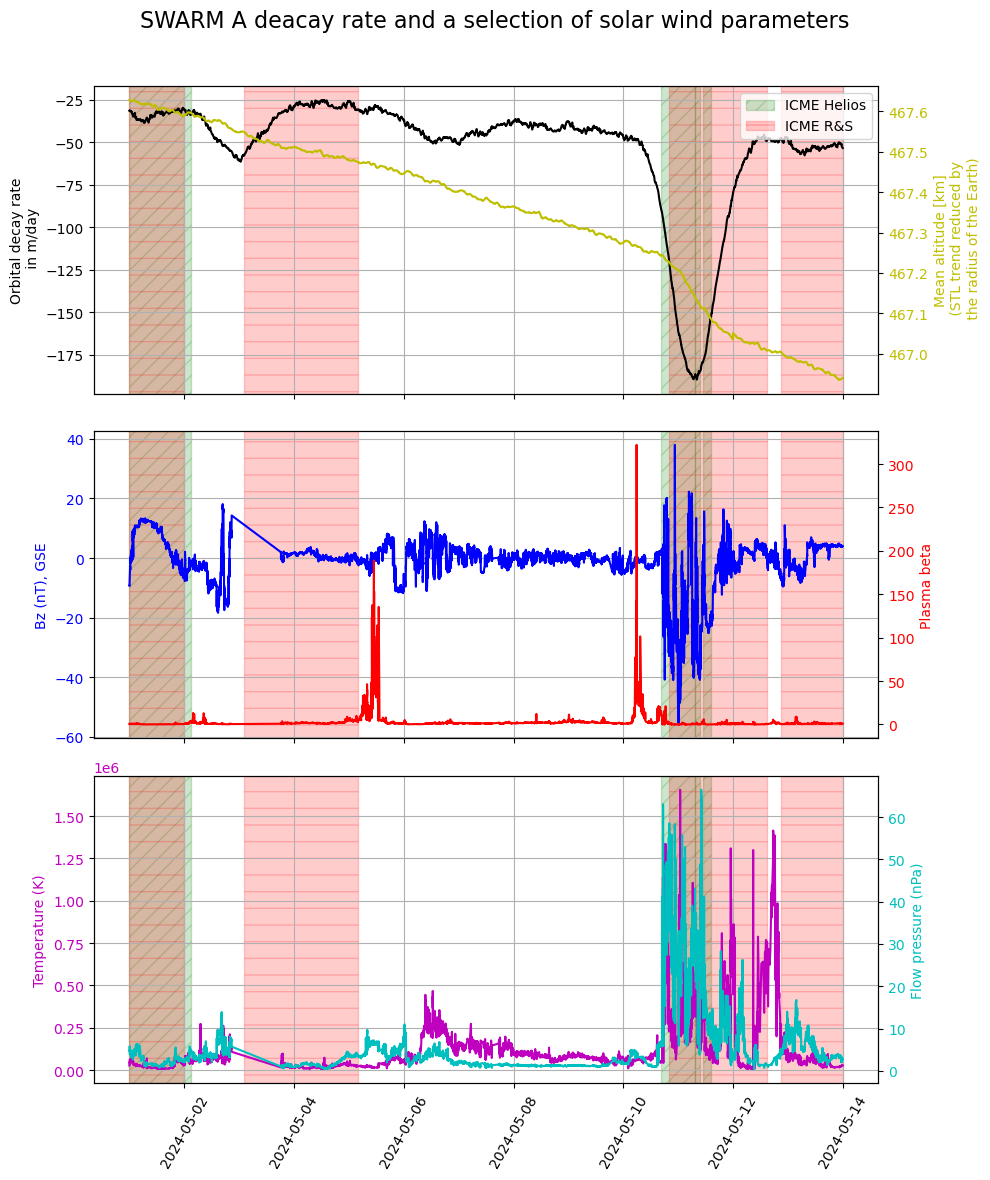

In [7]:
import matplotlib.dates as mdates
import numpy as np

# =========================== Input ===================================
start = GFOC_data[GFOC_data['time'] == '2024-05-01 00:00:00'].index[0]
end = GFOC_data[GFOC_data['time'] == '2024-05-14 00:00:00'].index[0]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# =====================================================================


# Time conversion
GFOC_time = GFOC_data['time'][start:end]
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')
SWMA_time = SWMA_data['time'][start:end]
SWMA_time = pd.to_datetime(SWMA_time, format='%Y-%m-%d %H:%M:%S')


# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=60)

# flags
flag_window = (GFOC_flags['GFOC_time'] >= GFOC_time.iloc[0]) & (GFOC_flags['GFOC_time'] <= GFOC_time.iloc[-1])
flag_subset = GFOC_flags[flag_window]

# downsample the flags to keep only one flag per 30 minutes (saves plotting time)
# flag_downsample = flag_subset[flag_subset['GFOC_time'].dt.minute % 30 == 0]

# downgrade by edges
def downsample_flags_by_edges(flag_series):
    """
    Keep only the first and last '1' in each contiguous block of 1s.
    All intermediate 1s are set to 0.
    """
    flags = flag_series.values.copy()
    if len(flags) < 3:
        return flag_series  # nothing to do on short series

    # Pad to detect edges at the boundaries
    padded = np.pad(flags, (1, 1), constant_values=0)
    
    # Find where a block of 1s starts and ends
    starts = np.where((padded[1:-1] == 1) & (padded[:-2] == 0))[0]
    ends = np.where((padded[1:-1] == 1) & (padded[2:] == 0))[0]

    # Zero out all flags
    new_flags = np.zeros_like(flags)

    # Restore only the start and end points
    new_flags[starts] = 1
    new_flags[ends] = 1

    return pd.Series(new_flags, index=flag_series.index)
flag_downgrade = flag_subset.copy()
flag_downgrade['Helios_flag'] = downsample_flags_by_edges(flag_downgrade['Helios_flag'])
flag_downgrade['RC_flag'] = downsample_flags_by_edges(flag_downgrade['RC_flag'])

# prepare flags for plotting
flag_values_RC = flag_downgrade['RC_flag'].values
flag_values_helios = flag_downgrade['Helios_flag'].values
flag_times = flag_downgrade['GFOC_time'].values
ones_indices_RC = np.where(flag_values_RC == 1)[0]
ones_indices_helios = np.where(flag_values_helios == 1)[0]

# Ensure even number of indices
if len(ones_indices_helios) % 2 != 0:
    print("Warning: Unmatched start/end in flags for helios — ignoring last point")
    ones_indices_helios = ones_indices_helios[:-1]  # Drop last if odd number
if len(ones_indices_RC) % 2 != 0:
    print("Warning: Unmatched start/end in flags for RC — ignoring last point")
    ones_indices_RC = ones_indices_RC[:-1]  # Drop last if odd number

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex =True)

# flags
for ax in axs:
    # Shock flags
    for t in flag_downgrade[flag_downgrade['Shock_flag'] == 1]['GFOC_time']:
        ax.axvspan(t - pd.Timedelta(seconds=15), t + pd.Timedelta(seconds=15), color='blue', alpha=0.2, label='Shock')

    # Helios flags
    for i in range(0, len(ones_indices_helios), 2):
        start_time = flag_times[ones_indices_helios[i]]
        end_time   = flag_times[ones_indices_helios[i+1]]
        ax.axvspan(start_time, end_time, color='green', alpha=0.2, hatch = '//', label='ICME Helios')

    # RC flags
    for i in range(0, len(ones_indices_RC), 2):
        start_time = flag_times[ones_indices_RC[i]]
        end_time   = flag_times[ones_indices_RC[i+1]]
        ax.axvspan(start_time, end_time, color='red', alpha=0.2, hatch = '-', label='ICME R&S')

handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(by_label.values(), by_label.keys(), loc='upper right')

# first figure
axs[0].plot(SWMA_time, -1 * SWMA_data['orbital_decay'][start:end], 'k')
axs[0].set_ylabel('Orbital decay rate\n in m/day', color = 'k')
axs[0].grid()
axs[0].tick_params(axis='y', labelcolor='k')
ax1 = axs[0].twinx()
ax1.plot(SWMA_time, SWMA_data['mean_altitude'][start:end], 'y')
# ax1.plot(SWMA_time, SWMA_data['unresolved'][start:end] / 1000 - 6378.137, 'y--')
ax1.plot(SWMA_time, SWMA_data['trend'][start:end] / 1000 - 6378.137, 'y:')
ax1.set_ylabel('Mean altitude [km]\n (STL trend reduced by\n the radius of the Earth)', color='y')
ax1.tick_params(axis='y', labelcolor='y')

# second figure
axs[1].plot(SWMA_time, SWMA_data['Bz GSE'][start:end], 'b')
axs[1].set_ylabel('Bz (nT), GSE', color = 'b')
axs[1].grid()
axs[1].tick_params(axis='y', labelcolor='b')
ax2 = axs[1].twinx()
ax2.plot(SWMA_time, SWMA_data['Plasma beta'][start:end], 'r')
ax2.set_ylabel('Plasma beta', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# third figure
axs[2].plot(SWMA_time, SWMA_data['Temperature (K)'][start:end], 'm')
axs[2].set_ylabel('Temperature (K)', color='m')
axs[2].grid()
axs[2].tick_params(axis='y', labelcolor='m')
format_ticks(axs[2], tick_interval, tick_step)
ax2 = axs[2].twinx()
ax2.plot(SWMA_time, SWMA_data['Flow pressure (nPa)'][start:end], 'c')
ax2.set_ylabel('Flow pressure (nPa)', color='c')
ax2.tick_params(axis='y', labelcolor='c')

# Set the figure title
fig.suptitle('SWARM A deacay rate and a selection of solar wind parameters', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

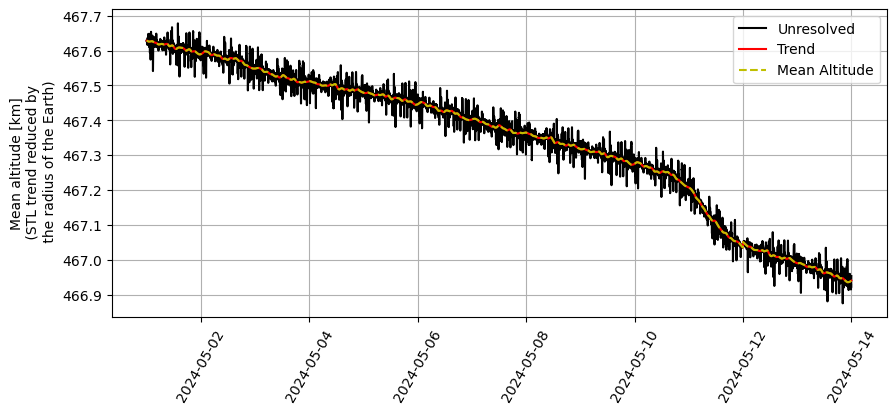

In [4]:
import matplotlib.dates as mdates

# =========================== Input ===================================
start = GFOC_data[GFOC_data['time'] == '2024-05-01 00:00:00'].index[0]
end = GFOC_data[GFOC_data['time'] == '2024-05-14 00:00:00'].index[0]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# =====================================================================


# Time conversion
GFOC_time = GFOC_data['time'][start:end]
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')
SWMA_time = SWMA_data['time'][start:end]
SWMA_time = pd.to_datetime(SWMA_time, format='%Y-%m-%d %H:%M:%S')


# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=60)

# Create a figure with three subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

# Plot the unresolved, trend, and mean altitude data
ax1.plot(SWMA_time, SWMA_data['unresolved'][start:end] / 1000 - 6378.137, 'k', label='Unresolved')
ax1.plot(SWMA_time, SWMA_data['trend'][start:end] / 1000 - 6378.137, 'r', label='Trend')
ax1.plot(SWMA_time, SWMA_data['mean_altitude'][start:end], 'y--', label='Mean Altitude')

# Set labels and grid
ax1.set_ylabel('Mean altitude [km]\n (STL trend reduced by\n the radius of the Earth)', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.grid()

# Format ticks
format_ticks(ax1, tick_interval, tick_step)

# Add legend
ax1.legend(loc='upper right')

# Show the plot
plt.show()

Levins Plot for GRACE-FO-A

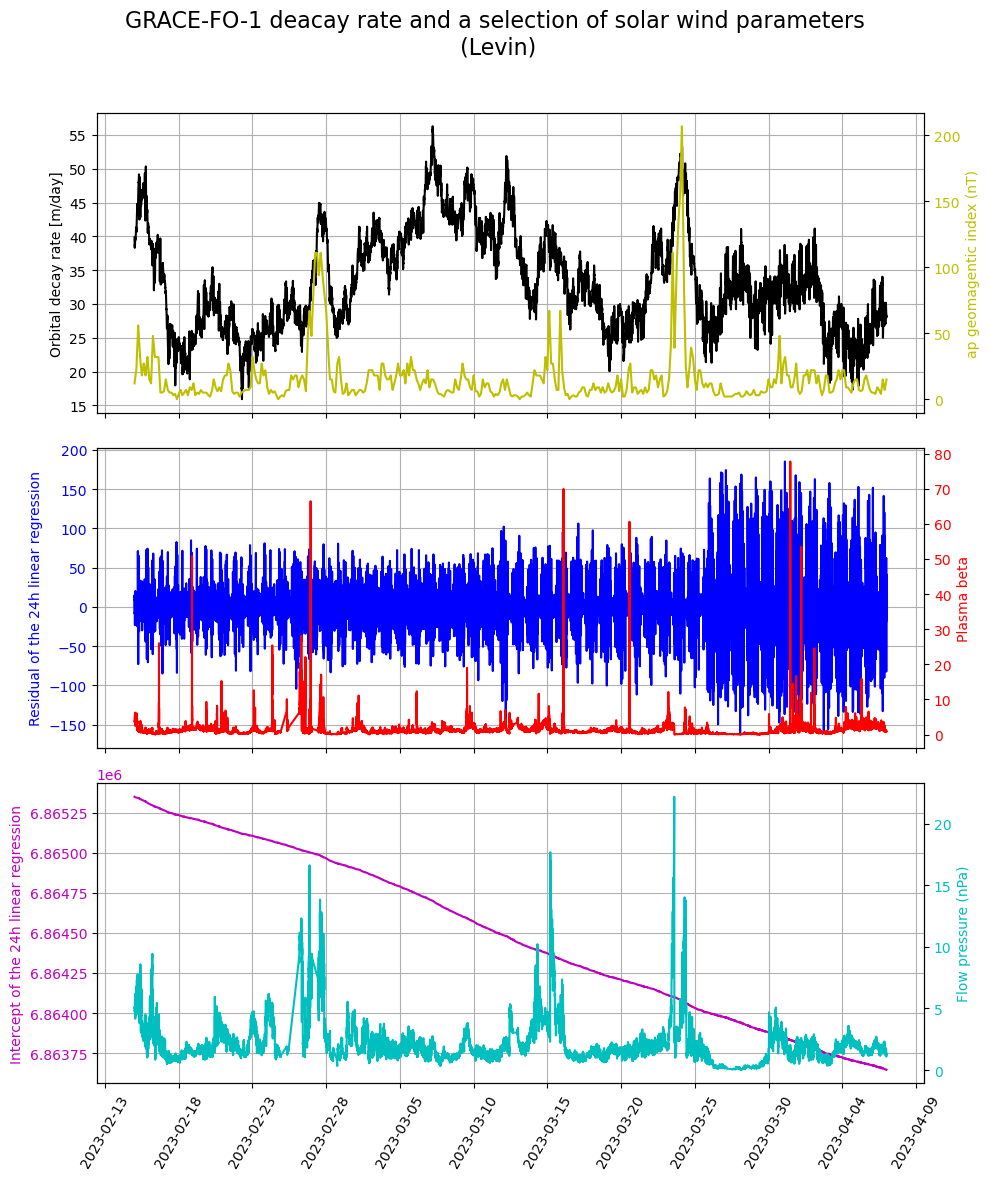

In [5]:
import matplotlib.dates as mdates

# =========================== Input ===================================
start = GFOC_data[GFOC_data['time'] == '2023-02-15 00:00:00'].index[0]
end = GFOC_data[GFOC_data['time'] == '2023-04-07 00:00:00'].index[0]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 5  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# =====================================================================


# Time conversion
GFOC_time = GFOC_data['time'][start:end]
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')
SWMA_time = SWMA_data['time'][start:end]
SWMA_time = pd.to_datetime(SWMA_time, format='%Y-%m-%d %H:%M:%S')


# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=60)

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex =True)

# first figure
axs[0].plot(GFOC_time, GFOC_data['orbital_decay'][start:end], 'k')
axs[0].set_ylabel('Orbital decay rate [m/day]', color = 'k')
axs[0].grid()
axs[0].tick_params(axis='y', labelcolor='k')
ax1 = axs[0].twinx()
ax1.plot(GFOC_time, GFOC_data['ap (LASP)'][start:end], 'y')
ax1.set_ylabel('ap geomagentic index (nT)', color='y')
ax1.tick_params(axis='y', labelcolor='y')

# second figure
axs[1].plot(GFOC_time, GFOC_data['res'][start:end], 'b')
axs[1].set_ylabel('Residual of the 24h linear regression', color = 'b')
axs[1].grid()
axs[1].tick_params(axis='y', labelcolor='b')
ax2 = axs[1].twinx()
ax2.plot(GFOC_time, GFOC_data['Plasma beta'][start:end], 'r')
ax2.set_ylabel('Plasma beta', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# third figure
axs[2].plot(GFOC_time, GFOC_data['intercept'][start:end], 'm')
axs[2].set_ylabel('Intercept of the 24h linear regression', color='m')
axs[2].grid()
axs[2].tick_params(axis='y', labelcolor='m')
format_ticks(axs[2], tick_interval, tick_step)
ax2 = axs[2].twinx()
ax2.plot(GFOC_time, GFOC_data['Flow pressure (nPa)'][start:end], 'c')
ax2.set_ylabel('Flow pressure (nPa)', color='c')
ax2.tick_params(axis='y', labelcolor='c')

# Set the figure title
fig.suptitle('GRACE-FO-1 deacay rate and a selection of solar wind parameters\n (Levin)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()